# blood_feature_selection_by_XGB_importance_scores_gender

#### This notebook:
* Load the EWAS aging data selecting for whole blood data
* Drop columns with more than 10% NaN
* Split data train/test 75/25
* Get sex as a feature (1 - Male, 0 - Female) from meta datafile
* Impute both train and test with mean of each train column.
* Run XGboost 50 time on training data with different train/validation splits (took 4hrs)
* Rank cpgs by frequency in top 100 importance scores
* Save rankings as pickled file 'cpgs_XGboost_blood_ranked_gender'
* Save dataframes with just the ranked columns

#### Conclusion
* of top 100 with swx as fea

#### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

#### Import our modules,
* age_predict is a python package we created for this project.
* to install it, in a terminal go to the age_predict folder and type: pip install .

In [2]:
import age_predict.Loading_EWAS_Aging_Data as le
import age_predict.Regression as rg
import age_predict.Pickle_unpickle as pu

In [3]:
import os
# View working directory
os.getcwd()
#os.chdir(')

'/Users/dcox/Desktop/EWAS-organized/blood/feature_selection'

#### Set paths

In [37]:
# Paths
path_to_data = '../../data/age_methylation_v1/'
path_to_meta_file = '../../data/age_methylation_v1/'
path_to_saved_features = '../saved_features/'

#### Set tissue of interest

In [5]:
tissue_of_interest = 'whole blood'

#### Load data

In [6]:
%%time
# The data file is processed one row at a time and the rows corresponding to 
# the tissue of interest are saved. This involves writing to a new csv file just 
# data from the tissue of interest and then reading it back in. All of this is done 
# with the function "load_EWAS_aging_by_tissue()" which uses the csv module.
# Reading it directly with Pandas is far to slow.

file_in = path_to_data + 'age_methylation_v1.txt'
file_out = path_to_data + tissue_of_interest + '_age_methylation_v1.txt'

df_t = le.load_EWAS_aging_by_tissue(file_in, file_out, search_term=tissue_of_interest,
                          num_rows='all', verbose=True)

finished line 10000
finished line 20000
finished line 30000
finished line 40000
finished line 50000
finished line 60000
finished line 70000
finished line 80000
finished line 90000
finished line 100000
finished line 110000
finished line 120000
finished line 130000
finished line 140000
finished line 150000
finished line 160000
finished line 170000
finished line 180000
finished line 190000
finished line 200000
finished line 210000
finished line 220000
finished line 230000
finished line 240000
finished line 250000
finished line 260000
finished line 270000
finished line 280000
finished line 290000
finished line 300000
finished line 310000
finished line 320000
finished line 330000
finished line 340000
finished line 350000
finished line 360000
finished line 370000
finished line 380000
finished line 390000
finished line 400000
finished line 410000
finished line 420000
finished line 430000
finished line 440000
finished line 450000
finished line 460000
finished line 470000
finished line 480000



#### Select age 20 and older

In [13]:
meta_file = path_to_meta_file + 'sample_age.txt'

def get_meta(meta_file, index, column, delimiter=' '):
    df_meta = pd.read_csv(meta_file, delimiter=delimiter)
    extracted = []
    for sample in index:
        extracted.append(df_meta.loc[sample, column])
    return extracted
        

In [14]:
# get sex from metadata file for the current samples
sex = get_meta(meta_file, df_t.index, 'sex', delimiter=' ')

In [15]:
len(sex)

1802

In [17]:
# Inserting columns for tissue and age and sex
# and setting age dtype to float and then rounding to int
# Converting sex from M mand F to 1 and 0

df_t.insert(2, 'sex', sex)
df_t.sex = 1*(df_t.sex=='M') # 1 = M, 0 = F

In [18]:
df_t_over20 = df_t[df_t.age >=20]

#### Split and impute data
* Drop row with more than 10% NaN
* Impute with means of train columns
* Split 75/25

In [19]:
%%time
df_train, df_test = le.splitting_and_imputing(df_t_over20, input_percent=10, 
                                           fraction_test=0.25, seed=2021)

CPU times: user 3min 52s, sys: 36 s, total: 4min 28s
Wall time: 4min 41s


In [20]:
df_train

sample_id,tissue,age,sex,cg02494853,cg03706273,cg04023335,cg05213048,cg15295597,cg26520468,cg27539833,...,ch.22.569473R,ch.22.38010425R,ch.22.707968R,ch.22.740407F,ch.22.757911F,ch.22.43177094F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R
GSM2334366,whole blood,94,0,0.078,0.205,0.139,0.904,0.120,0.970,0.912,...,0.109,0.016,0.003,0.006000,0.010000,0.004,0.010,0.001000,0.047,0.012
GSM989863,whole blood,101,0,0.013,0.008,0.117,0.756,0.033,0.958,0.933,...,0.152,0.015,0.005,0.008000,0.009000,0.002,0.009,0.001000,0.057,0.008
GSM1443696,whole blood,99,1,0.013,0.017,0.477,0.715,0.017,0.966,0.932,...,0.122,0.005,0.006,0.011000,0.027000,0.000,0.003,0.002000,0.033,0.003
GSM1069241,whole blood,99,1,0.013,0.017,0.477,0.715,0.017,0.966,0.932,...,0.122,0.005,0.006,0.011000,0.027000,0.000,0.003,0.002000,0.033,0.003
GSM1572442,whole blood,112,0,0.036,0.255,0.260,0.690,0.065,0.983,0.951,...,0.138,0.011,0.004,0.012000,0.037000,0.002,0.006,0.007000,0.036,0.150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1498536,whole blood,48,0,0.010,0.048,0.068,0.575,0.034,0.981,0.946,...,0.155,0.028,0.007,0.019000,0.018202,0.002,0.011,0.003000,0.052,0.016
GSM1868331,whole blood,48,1,0.024,0.019,0.635,0.848,0.035,0.958,0.944,...,0.127,0.009,0.004,0.001000,0.011000,0.004,0.005,0.000000,0.036,0.097
GSM2337452,whole blood,48,0,0.027,0.032,0.145,0.661,0.068,0.964,0.936,...,0.133,0.016,0.028,0.008000,0.017000,0.003,0.009,0.002000,0.054,0.107
GSM1653326,whole blood,48,1,0.033,0.023,0.529,0.772,0.064,0.956,0.946,...,0.089,0.001,0.009,0.008616,0.018202,0.000,0.003,0.002595,0.034,0.076


In [21]:
df_test

sample_id,tissue,age,sex,cg02494853,cg03706273,cg04023335,cg05213048,cg15295597,cg26520468,cg27539833,...,ch.22.569473R,ch.22.38010425R,ch.22.707968R,ch.22.740407F,ch.22.757911F,ch.22.43177094F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R
GSM1345728,whole blood,38,0,0.020,0.037,0.100,0.529,0.025,0.975,0.924,...,0.12600,0.015,0.001,0.009,0.010,0.007,0.012,0.003,0.041,0.009
GSM1425726,whole blood,79,1,0.042,0.039,0.647,0.854,0.067,0.968,0.934,...,0.13377,0.008,0.002,0.007,0.007,0.002,0.006,0.000,0.023,0.006
GSM1886430,whole blood,24,1,0.022,0.021,0.501,0.676,0.032,0.966,0.939,...,0.20100,0.009,0.007,0.009,0.011,0.004,0.010,0.003,0.057,0.004
GSM2337042,whole blood,25,0,0.016,0.030,0.120,0.534,0.028,0.974,0.924,...,0.09600,0.026,0.002,0.008,0.016,0.004,0.020,0.002,0.065,0.008
GSM1886440,whole blood,23,1,0.013,0.011,0.607,0.862,0.090,0.957,0.871,...,0.18100,0.027,0.013,0.010,0.048,0.001,0.005,0.003,0.039,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM990569,whole blood,85,1,0.030,0.031,0.692,0.841,0.031,0.954,0.916,...,0.13900,0.016,0.007,0.014,0.009,0.003,0.011,0.002,0.039,0.112
GSM1345649,whole blood,49,1,0.036,0.029,0.599,0.706,0.036,0.958,0.929,...,0.13000,0.014,0.004,0.004,0.010,0.002,0.005,0.001,0.034,0.003
GSM2334025,whole blood,26,0,0.032,0.034,0.169,0.577,0.047,0.989,0.935,...,0.16000,0.018,0.008,0.007,0.020,0.002,0.011,0.002,0.047,0.007
GSM989849,whole blood,93,1,0.059,0.051,0.670,0.775,0.066,0.961,0.932,...,0.13500,0.026,0.006,0.008,0.005,0.007,0.011,0.001,0.046,0.120


#### Run XGboost 50 times to identify most importance cpgs by importance score
The following hyperparameters were used (identified as ~ optimal by cv)
* n_estimators=200
* n_estimators=200,
* min_child_weight=1,
* max_depth=3,
* subsample=0.7,
* colsample_bytree=0.5,
* learning_rate=0.1)

In [22]:
%%time
# Running XGboost on Train dataset 50 times with 50 different train/val splits, all cpgs
# This can take hours 
df_importance, rms_train, rms_test, r2_train, r2_test = rg.repeat_XGBoost(df_train, 50, test_size=0.20)

1 r^2 validation = 0.9256039898440561
2 r^2 validation = 0.9279250050839559
3 r^2 validation = 0.9378414485904183
4 r^2 validation = 0.9393641843316795
5 r^2 validation = 0.9212774063067054
6 r^2 validation = 0.9200209327860466
7 r^2 validation = 0.9155077555988405
8 r^2 validation = 0.9306102988471734
9 r^2 validation = 0.9334554495516821
10 r^2 validation = 0.9231612427842285
11 r^2 validation = 0.935564458069769
12 r^2 validation = 0.9142433389959893
13 r^2 validation = 0.9190494446559606
14 r^2 validation = 0.9467784751433791
15 r^2 validation = 0.9344161075195974
16 r^2 validation = 0.8971804844721348
17 r^2 validation = 0.9119724144451744
18 r^2 validation = 0.9234950533717657
19 r^2 validation = 0.9197612194553196
20 r^2 validation = 0.9034533377163865
21 r^2 validation = 0.9069084077300086
22 r^2 validation = 0.9041071282561368
23 r^2 validation = 0.9314943165845355
24 r^2 validation = 0.897814464888657
25 r^2 validation = 0.9204003965821609
26 r^2 validation = 0.91513068954288

#### Write the importance score from the 50 trials results to a file

In [23]:
file = 'df_importance_EWAS_age_' + tissue_of_interest + '_50_trials.csv'
df_importance.to_csv(file)
# df_importance = pd.read_csv('./blood/df_importance_EWAS_age_whole_blood_50_trials.csv' , index_col=0)

#### Finding cpgs with on average the highest importance scores
* see mean column in the df below.

In [24]:
df_imp_sorted = rg.importances_sorted_by_mean(df_importance)

#### Make a histogram of the frequency of cgs in the top 100 importance score in the 50 trials

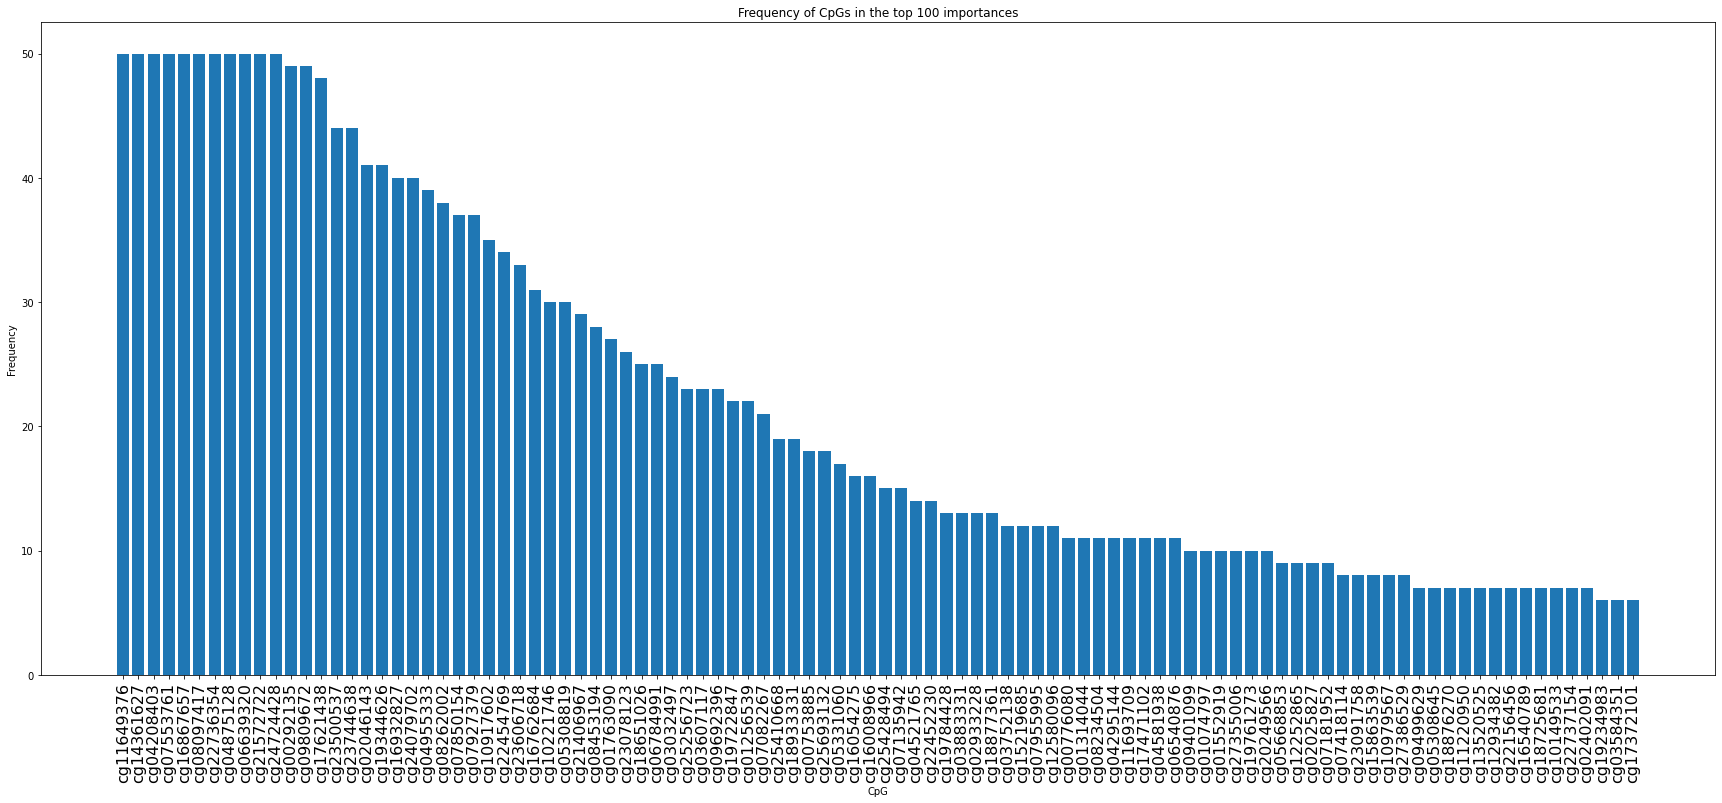

In [25]:

indices, cpgs_per_trial, hist = rg.histogram_of_top_CpGs_by_importance(df_importance, 100)

In [40]:
cpgs_XGboost_blood_ranked_gender = hist.index.values

In [41]:
cpgs_XGboost_blood_ranked_gender.shape

(2263,)

#### Saving Rankings

In [42]:
pu.pickle_object(cpgs_XGboost_blood_ranked_gender, 'cpgs_XGboost_blood_ranked_gender')

pickled as cpgs_XGboost_blood_ranked_gender


#### Save train and test dataframes with columns from just the ranked cpgs
* 2263 columns kept

In [47]:
df_train_ranked_gen = df_train[cpgs_XGboost_blood_ranked_gender]
df_train_ranked_gen.insert(0, 'age', df_train.age)
df_train_ranked_gen.insert(0, 'tissue', df_train.tissue)
df_train_ranked_gen.insert(2, 'sex', df_train.sex)

df_test_ranked_gen = df_test[cpgs_XGboost_blood_ranked_gender]
df_test_ranked_gen.insert(0, 'age', df_test.age)
df_test_ranked_gen.insert(0, 'tissue', df_test.tissue)
df_test_ranked_gen.insert(2, 'sex', df_test.sex)

df_train_ranked_gen.to_csv('df_train_ranked_gen.csv')
df_test_ranked_gen.to_csv('df_test_ranked_gen.csv')

In [48]:
cpgs_XGboost_blood_ranked = pu.get_pickled_object(path_to_saved_features + 'cpgs_XGboost_blood_ranked')
rg.count_common_cpgs(cpgs_XGboost_blood_ranked[:100], cpgs_XGboost_blood_ranked_gender[:100], verbose=True)

Common cpgs
0 cg04875128
1 cg16867657
2 cg14361627
3 cg24724428
4 cg00292135
5 cg04208403
6 cg24079702
7 cg11649376
8 cg23500537
9 cg08097417
10 cg23744638
11 cg06639320
12 cg17621438
13 cg21572722
14 cg04955333
15 cg09809672
16 cg07553761
17 cg22454769
18 cg22736354
19 cg19344626
20 cg07927379
21 cg07850154
22 cg08453194
23 cg08262002
24 cg02046143
25 cg01763090
26 cg19722847
27 cg10917602
28 cg07082267
29 cg23606718
30 cg16932827
31 cg03032497
32 cg02933228
33 cg18651026
34 cg05308819
35 cg16762684
36 cg21406967
37 cg03607117
38 cg09692396
39 cg07955995
40 cg18877361
41 cg25410668
42 cg25256723
43 cg05331060
44 cg06540876
45 cg12252865
46 cg18933331
47 cg10221746
48 cg23091758
49 cg00753885
50 cg23078123
51 cg10149533
52 cg01256539
53 cg01074797
54 cg03883331
55 cg11693709
56 cg00776080
57 cg04581938
58 cg17471102
62 cg07135942
63 cg02025827
65 cg09499629
68 cg04521765
69 cg03584351
71 cg16054275
73 cg25428494
76 cg19784428
77 cg01314044
81 cg03752138
83 cg22452230
85 cg05668853
86 c

['cg04875128',
 'cg16867657',
 'cg14361627',
 'cg24724428',
 'cg00292135',
 'cg04208403',
 'cg24079702',
 'cg11649376',
 'cg23500537',
 'cg08097417',
 'cg23744638',
 'cg06639320',
 'cg17621438',
 'cg21572722',
 'cg04955333',
 'cg09809672',
 'cg07553761',
 'cg22454769',
 'cg22736354',
 'cg19344626',
 'cg07927379',
 'cg07850154',
 'cg08453194',
 'cg08262002',
 'cg02046143',
 'cg01763090',
 'cg19722847',
 'cg10917602',
 'cg07082267',
 'cg23606718',
 'cg16932827',
 'cg03032497',
 'cg02933228',
 'cg18651026',
 'cg05308819',
 'cg16762684',
 'cg21406967',
 'cg03607117',
 'cg09692396',
 'cg07955995',
 'cg18877361',
 'cg25410668',
 'cg25256723',
 'cg05331060',
 'cg06540876',
 'cg12252865',
 'cg18933331',
 'cg10221746',
 'cg23091758',
 'cg00753885',
 'cg23078123',
 'cg10149533',
 'cg01256539',
 'cg01074797',
 'cg03883331',
 'cg11693709',
 'cg00776080',
 'cg04581938',
 'cg17471102',
 'cg07135942',
 'cg02025827',
 'cg09499629',
 'cg04521765',
 'cg03584351',
 'cg16054275',
 'cg25428494',
 'cg197844

In [45]:
rg.count_common_cpgs(cpgs_XGboost_blood_ranked[:1000], cpgs_XGboost_blood_ranked_gender[:1000], verbose=True)

Common cpgs
0 cg04875128
1 cg16867657
2 cg14361627
3 cg24724428
4 cg00292135
5 cg04208403
6 cg24079702
7 cg11649376
8 cg23500537
9 cg08097417
10 cg23744638
11 cg06639320
12 cg17621438
13 cg21572722
14 cg04955333
15 cg09809672
16 cg07553761
17 cg22454769
18 cg22736354
19 cg19344626
20 cg07927379
21 cg07850154
22 cg08453194
23 cg08262002
24 cg02046143
25 cg01763090
26 cg19722847
27 cg10917602
28 cg07082267
29 cg23606718
30 cg16932827
31 cg03032497
32 cg02933228
33 cg18651026
34 cg05308819
35 cg16762684
36 cg21406967
37 cg03607117
38 cg09692396
39 cg07955995
40 cg18877361
41 cg25410668
42 cg25256723
43 cg05331060
44 cg06540876
45 cg12252865
46 cg18933331
47 cg10221746
48 cg23091758
49 cg00753885
50 cg23078123
51 cg10149533
52 cg01256539
53 cg01074797
54 cg03883331
55 cg11693709
56 cg00776080
57 cg04581938
58 cg17471102
59 cg22796704
60 cg20273670
61 cg03404339
62 cg07135942
63 cg02025827
64 cg04084157
65 cg09499629
66 cg17110586
67 cg14174378
68 cg04521765
69 cg03584351
70 cg18343474
71 c

['cg04875128',
 'cg16867657',
 'cg14361627',
 'cg24724428',
 'cg00292135',
 'cg04208403',
 'cg24079702',
 'cg11649376',
 'cg23500537',
 'cg08097417',
 'cg23744638',
 'cg06639320',
 'cg17621438',
 'cg21572722',
 'cg04955333',
 'cg09809672',
 'cg07553761',
 'cg22454769',
 'cg22736354',
 'cg19344626',
 'cg07927379',
 'cg07850154',
 'cg08453194',
 'cg08262002',
 'cg02046143',
 'cg01763090',
 'cg19722847',
 'cg10917602',
 'cg07082267',
 'cg23606718',
 'cg16932827',
 'cg03032497',
 'cg02933228',
 'cg18651026',
 'cg05308819',
 'cg16762684',
 'cg21406967',
 'cg03607117',
 'cg09692396',
 'cg07955995',
 'cg18877361',
 'cg25410668',
 'cg25256723',
 'cg05331060',
 'cg06540876',
 'cg12252865',
 'cg18933331',
 'cg10221746',
 'cg23091758',
 'cg00753885',
 'cg23078123',
 'cg10149533',
 'cg01256539',
 'cg01074797',
 'cg03883331',
 'cg11693709',
 'cg00776080',
 'cg04581938',
 'cg17471102',
 'cg22796704',
 'cg20273670',
 'cg03404339',
 'cg07135942',
 'cg02025827',
 'cg04084157',
 'cg09499629',
 'cg171105